### Reference: Deep Learning by Francois Chollet

### A Basic Example

The derivative of a tensor function is called a gradient. Gradients are just generalization of the concept of derivatives to functions that take tensors as inputs. 

The gradient of a tensor function represents the curvature of the multidimensional surface described by the function. It characterizes how the output of the function varies when its input parameters vary.

In [1]:
import tensorflow as tf
from tensorflow import keras as kr

In [9]:
import matplotlib.pyplot as plt

In [32]:
import numpy as np

In [2]:
# We will again work with the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = kr.datasets.mnist.load_data()

In [4]:
print(f"The shape of training images dataset is : {train_images.shape}")
print(f"The shape of testing images dataset is : {test_images.shape}")

The shape of training images dataset is : (60000, 28, 28)
The shape of testing images dataset is : (10000, 28, 28)


Each image is represented as an array of shape: (28, 28)


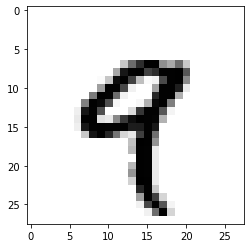

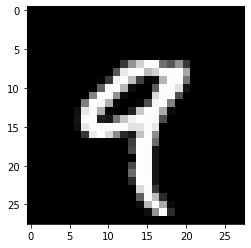

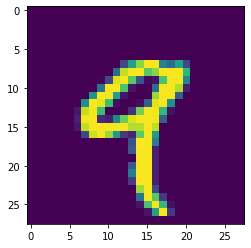

In [18]:
print(
    f"Each image is represented as an array of shape: {train_images[0].shape}")
"""
We can look at each image using various tools, here we use matplotlib and generate a
reverse graymap image, graymap image, and a default setting('viridis') image from an array for better visualtion
"""
plt.imshow(train_images[4], cmap='gray_r')
plt.show()

plt.imshow(train_images[4], cmap='gray')
plt.show()

plt.imshow(train_images[4])
plt.show()

In [20]:
"""
We will now flatten each image into a 1-D array for the network
"""
train_images = train_images.reshape((60000, 28*28))
test_images = test_images.reshape((10000, 28*28))

"""
Now we will standardize the 1-D arrays by dividing by 255,
as the highest pixel value is 255, all values of the 1-D arrays
will now be in the interval [0,1] due to standardization.
"""

train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [21]:
print(f"The shape of training dataset after preprocessing is: {train_images.shape}")
print(f"The shape of testing dataset after preprocessing is: {test_images.shape}")

The shape of training dataset after preprocessing is: (60000, 784)
The shape of testing dataset after preprocessing is: (10000, 784)


### The Dense Layer

A dense layer applies the following transformation during a forward pass,

$Input(X) \implies WX + b \implies ActivationFunction(WX + b) \implies Output$, where the parameter matrix $W$ is randomly initialized, usually from a uniform distribution. The values of the bias vector $b$ is usually set to all $0's$ or all $1's$.

In [23]:
"""
Now we will implement a Dense layer manually.
"""

class Dense:
    def __init__(self, input_size, output_size, activation):
        self.activation = activation

        w_shape = (input_size, output_size)
        w_initial_value = tf.random.uniform(w_shape, minval=0, maxval=1e-1)
        self.W = tf.Variable(w_initial_value)
        
        b_shape = (output_size,)
        b_initial_value = tf.zeros(b_shape)
        self.b = tf.Variable(b_initial_value)

    def __call__(self, inputs):
        return self.activation(tf.matmul(inputs, self.W) + self.b)
    
    # This property method is convenient if we want to retrieve the values of weights and biases at any step.
    @property
    def weights(self):
        return [self.W, self.b]

### The Sequential Model

In [24]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, inputs):
        x = inputs
        for layer in self.layers:
            x = layer(x)
        return x

    @property
    def weights(self):
        weights = []
        for layer in self.layers:
            weights = weights + layer.weights
        return weights

### Adding Dense Layers to the Sequential Model

In [28]:
"""
Following the theory of neural networks, we use the ReLU activation function for our hidden layer so that it can
extract representational information about the dataset nonlinearly.

For the output layer we use the Softmax function as it is a Multinoulli or Multiclass classification problem.
"""

model = Sequential([
    Dense(input_size=28*28, output_size=512, activation=tf.nn.relu),
    Dense(input_size=512, output_size=10, activation=tf.nn.softmax)
])

# As two dense layers have been added each containing two 'weight' matrices one for W and one for b, the model should have 4 'weight'
# matrices in its structure
assert len(model.weights) == 4

### Dividing the Data Into Batches

Now we will train our model on the dataset using small batches of data, instead of training the model on the whole dataset. This makes things less computationally expensive when implementing backpropagation. As the model will then have to compute and update less gradients. 

In [27]:
import math

class BatchGenerator:
    def __init__(self, images, labels, batch_size=128):
        # Ensure that equal amount of inputs and corresponding target outputs are fed.
        assert len(images) == len(labels)
        self.index = 0
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.num_batches = math.ceil(len(images)/batch_size)
    
    def next(self):
        images = self.images[self.index : self.index + self.batch_size]
        labels = self.labels[self.index : self.index + self.batch_size]
        self.index = self.index + self.batch_size
        return images, labels
    

### Implementing Forward and Backward Pass

A training step involves the folloing flow:

__Forward Pass__

1. Compute the predictions of the model for the images in the batch.
2. Compute the loss value for these predictions, given the actual labels.

__Backward Pass__

3. Compute the gradient of the loss with regard to the model’s weights.
4. Move the weights by a small amount in the direction opposite to the gradient.

In [29]:
loss_function = tf.keras.losses.sparse_categorical_crossentropy #Cross Entropy for Multinoulli Classification

def update_weights(gradients, weights):
    learning_rate = 1e-3
    for gradient, weight in zip(gradients, weights):
        weight.assign_sub(gradient*learning_rate)

def one_training_step(model, images_batch, labels_batch):
    with tf.GradientTape() as tape:
        predictions = model(images_batch)
        per_sample_losses = loss_function(labels_batch, predictions)
        average_loss = tf.reduce_mean(per_sample_losses)
    gradients = tape.gradient(average_loss, model.weights)
    update_weights(gradients, model.weights)
    return average_loss    

### The Full Training Loop

We will train the model for $10$ epochs, that is train it on the full dataset $10$ times using small batches to train at each epoch.

In [30]:
def fit(model, images, labels, epochs, batch_size=128):
    for epoch_counter in range(epochs):
        print(f"Epoch {epoch_counter}")

        batch_generator = BatchGenerator(images, labels)

        for batch_counter in range(batch_generator.num_batches):
            images_batch, labels_batch = batch_generator.next()
            loss = one_training_step(model, images_batch, labels_batch)
            if batch_counter % 100 == 0:
                print(f"Loss at batch {batch_counter} is: {loss:.2f}")


In [31]:
"""
We will now train our model on the preprocessed data we obtained at the beginning.  
"""
fit(model, train_images, train_labels, epochs=10, batch_size=128)

Epoch 0
Loss at batch 0 is: 4.62
Loss at batch 100 is: 2.26
Loss at batch 200 is: 2.25
Loss at batch 300 is: 2.10
Loss at batch 400 is: 2.22
Epoch 1
Loss at batch 0 is: 1.92
Loss at batch 100 is: 1.90
Loss at batch 200 is: 1.86
Loss at batch 300 is: 1.72
Loss at batch 400 is: 1.83
Epoch 2
Loss at batch 0 is: 1.59
Loss at batch 100 is: 1.59
Loss at batch 200 is: 1.53
Loss at batch 300 is: 1.43
Loss at batch 400 is: 1.51
Epoch 3
Loss at batch 0 is: 1.33
Loss at batch 100 is: 1.35
Loss at batch 200 is: 1.26
Loss at batch 300 is: 1.22
Loss at batch 400 is: 1.27
Epoch 4
Loss at batch 0 is: 1.13
Loss at batch 100 is: 1.17
Loss at batch 200 is: 1.06
Loss at batch 300 is: 1.05
Loss at batch 400 is: 1.11
Epoch 5
Loss at batch 0 is: 0.98
Loss at batch 100 is: 1.02
Loss at batch 200 is: 0.92
Loss at batch 300 is: 0.93
Loss at batch 400 is: 0.99
Epoch 6
Loss at batch 0 is: 0.87
Loss at batch 100 is: 0.91
Loss at batch 200 is: 0.81
Loss at batch 300 is: 0.84
Loss at batch 400 is: 0.90
Epoch 7
Loss 

### Evaluation

In [33]:
predictions = model(test_images)
predictions = predictions.numpy()
predicted_labels = np.argmax(predictions, axis=1)
matches = predicted_labels == test_labels
print(f"Accuracy: {matches.mean():.2f}")

Accuracy: 0.82


As we can see that this model reports and accuracy of 82%, that is our trained model can correctly guess the labels of the test images for more than 80% of cases.

### Visualizing the Results

In [35]:
import seaborn as sns
sns.set()

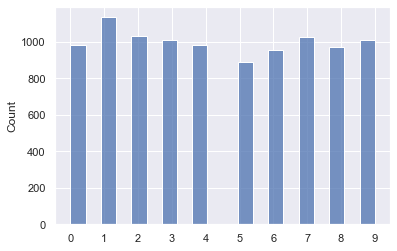

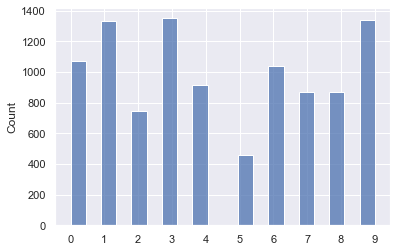

In [45]:
sns.histplot(test_labels)
plt.xticks(np.arange(0, 10, 1));
plt.show()

sns.histplot(predicted_labels)
plt.xticks(np.arange(0, 10, 1));
plt.show()